In [1]:
# get all imports out of the way
import tensorneat as tn
import jax.numpy as jnp
import pandas as pd
# get all the symbols we can pull live data for
import os

# Path to the directory
directory_path = "hist_data/stocks/single"

# List all files in the directory
files = os.listdir(directory_path)

live_syms = [file.split('_')[0] for file in files]

# drop nans split by symbol and join on date
file_path = "hist_data/stocks/sp500_stocks.csv"  # Update this path if needed
df = pd.read_csv(file_path)

df = df.dropna()

symbols = df['Symbol'].unique()
symbol_dfs = {symbol: df[df['Symbol'] == symbol] for symbol in symbols}

merged_df = symbol_dfs[symbols[0]].set_index('Date')

for symbol in symbols[1:]:
    symbol_data = symbol_dfs[symbol].set_index('Date')
    if (len(symbol_data) == 3768 and symbol in live_syms):
        merged_df = merged_df.join(symbol_data, how='inner', rsuffix=f"_{symbol}")

tensorneat_input = merged_df.to_numpy()

print(tensorneat_input.shape)

(3768, 1029)


In [2]:
# create a target array
non_feature_cols = merged_df.columns
close_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep

#feature_df = merged_df[close_columns].copy()
for c in close_columns:
    '''
    merged_df[f'{c}_ma5'] = merged_df[c].rolling(window=5).mean()
    merged_df[f'{c}_ma10'] = merged_df[c].rolling(window=10).mean()
    merged_df[f'{c}_ma20'] = merged_df[c].rolling(window=20).mean()
    merged_df[f'{c}_avg_change_13'] = merged_df[c].pct_change().rolling(window=13).mean()
    merged_df[f'{c}_stddev_13'] = merged_df[c].pct_change().rolling(window=13).std()
    '''
    merged_df[f'{c}_pct_change'] = merged_df[c].pct_change(5)
    merged_df[f'{c}_pct_change_13'] = merged_df[c].pct_change(13)
    merged_df[f'{c}_pct_change_34'] = merged_df[c].pct_change(34)
print(merged_df.values.shape)

feature_cols = [col for col in merged_df.columns if col not in non_feature_cols]

# shift target and adjust features accordingly
target = merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = merged_df[feature_cols].values
print(target.shape)

print(features.shape)

C:\Users\nick5\AppData\Local\Temp\ipykernel_32256\1748339010.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'{c}_pct_change'] = merged_df[c].pct_change(5)
C:\Users\nick5\AppData\Local\Temp\ipykernel_32256\1748339010.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'{c}_pct_change_13'] = merged_df[c].pct_change(13)
C:\Users\nick5\AppData\Local\Temp\ipykernel_32256\1748339010.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

(3768, 1470)
(3766, 147)
(3768, 441)


In [3]:
import jax.numpy as jnp
train_test_split = 0.9

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")


Sample Count: 3766
Train Size: 3389
Shape of INPUTS: (3389, 441)
Shape of RETURNS: (3389, 147)


In [4]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblemTopK(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params, k=3):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)

      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)

      # Gather the rewards for the top-k indices
      rewards = jnp.take_along_axis(RETURNS, topk_indices, axis=1)

      # Calculate the weighted reward
      weighted_rewards = jnp.sum(rewards, axis=1)
      return jnp.mean(weighted_rewards)

  def show(self, state, randkey, act_func, params, k=3, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Move data to host numpy
      from jax import device_get
      import numpy as np
      topk_indices_np = np.asarray(device_get(topk_indices))
      softmax_weights_np = np.asarray(device_get(softmax_weights))
      returns_np = np.asarray(device_get(TEST_RETURNS))
      
      # Calculate performance based on top-k weighted rewards
      perf = 100.0
      perf_hist = []
      todays_syms = [live_syms[i] for i in topk_indices_np[-1]]
      print("Today's selected symbols:", todays_syms)
      for i in range(len(topk_indices_np)-2):
          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[i]]
          
          # Calculate the weighted reward
          weighted_reward = np.sum(softmax_weights_np[i] * rewards)
          
          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))
      
      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

  def show_averaged(self, state, randkey, act_func, params_list, k=3, *args, **kwargs):
      """
      Show the averaged performance of multiple networks.
      
      Args:
          state: The state of the problem.
          randkey: Random key for JAX operations.
          act_func: Activation function for the networks.
          params_list: List of network parameters (one for each network).
          k: Number of top-k actions to consider.
      """
      import numpy as np
      from jax import device_get
      import matplotlib.pyplot as plt

      # Initialize performance tracking
      perf = 100.0
      perf_hist = []

      # Iterate over the test inputs
      for i in range(TEST_INPUTS.shape[0]):
          # Collect actions from all networks
          actions_list = [
              jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS[i:i+1, :])
              for params in params_list
          ]

          # Average the actions across all networks
          avg_actions = jnp.mean(jnp.stack(actions_list, axis=0), axis=0)

          # Get the top-k values and indices
          topk_values, topk_indices = jax.lax.top_k(avg_actions, k)

          # Apply softmax to the top-k values to get weights
          softmax_weights = jax.nn.softmax(topk_values, axis=1)

          # Move data to host numpy
          topk_indices_np = np.asarray(device_get(topk_indices))
          softmax_weights_np = np.asarray(device_get(softmax_weights))
          returns_np = np.asarray(device_get(TEST_RETURNS))

          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[0]]
          weighted_reward = np.sum(softmax_weights_np[0] * rewards)

          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))

      # Plot the performance history
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblemTopK()



In [ ]:
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import DefaultGenome, BiasNode, DefaultConn, DefaultMutation
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm

# Construct the pipeline and run
pipeline = Pipeline(
    algorithm=NEAT(
        pop_size=233,
        species_size=10,
        survival_threshold=0.2,
        compatibility_threshold=0.8,
        genome=DefaultGenome(
            max_nodes=700,
            max_conns=2000,
            num_inputs=features.shape[1],
            num_outputs=target.shape[1],
            init_hidden_layers=(2,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblemTopK(),
    generation_limit=55,
    fitness_target=.1,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_extra_features"
)

# initialize state
state = pipeline.setup()
# run until terminate
state, best = pipeline.auto_run(state)
# show result
pipeline.show(state, best)
state.save("./model_archive/tensorneat_extra_features/evolving_state.pkl")

save to ./model_archive/tensorneat_extra_features
initializing
initializing finished
start compile
compile finished, cost time: 4.000077s
Generation: 1, Cost time: 461795.84ms
 	fitness: valid cnt: 233, max: 0.0033, min: 0.0004, mean: 0.0019, std: 0.0006

	node counts: max: 592, min: 590, mean: 591.03
 	conn counts: max: 1766, min: 1175, mean: 1721.21
 	species: 1, [233]

Generation: 2, Cost time: 454421.03ms
 	fitness: valid cnt: 233, max: 0.0043, min: 0.0011, mean: 0.0024, std: 0.0006

	node counts: max: 593, min: 589, mean: 591.09
 	conn counts: max: 1767, min: 588, mean: 1630.82
 	species: 1, [233]

Generation: 3, Cost time: 456485.21ms
 	fitness: valid cnt: 233, max: 0.0051, min: 0.0013, mean: 0.0031, std: 0.0007

	node counts: max: 594, min: 589, mean: 591.00
 	conn counts: max: 1768, min: 587, mean: 1429.07
 	species: 1, [233]

Generation: 4, Cost time: 451107.76ms
 	fitness: valid cnt: 233, max: 0.0054, min: 0.0018, mean: 0.0038, std: 0.0007

	node counts: max: 594, min: 588, m

KeyboardInterrupt: 

In [65]:
sym_columns = [col for col in merged_df.columns if 'Symbol' in col]
sym_list = merged_df[sym_columns].iloc[0].values
print(sym_list)

['AOS' 'ABT' 'AES' 'ALB' 'ALL' 'GOOG' 'MO' 'AMZN' 'AXP' 'AMP' 'APH' 'ADM'
 'AJG' 'T' 'AXON' 'BKR' 'BAX' 'BDX' 'BBY' 'BK' 'BWA' 'BSX' 'BRO' 'BLDR'
 'COF' 'KMX' 'CCL' 'CAT' 'CE' 'CVX' 'CSCO' 'C' 'CLX' 'CME' 'CMCSA' 'ED'
 'STZ' 'GLW' 'CSGP' 'DE' 'DXCM' 'DLR' 'DG' 'DPZ' 'DOV' 'DHI' 'DTE' 'EMN'
 'EIX' 'EA' 'EQT' 'EFX' 'EQIX' 'EQR' 'ESS' 'EL' 'EXPE' 'FFIV' 'FDS' 'FAST'
 'FRT' 'FDX' 'FSLR' 'FTNT' 'BEN' 'FCX' 'GIS' 'GPN' 'HIG' 'HSIC' 'HRL'
 'HST' 'IEX' 'INCY' 'PODD' 'ICE' 'IFF' 'IP' 'ISRG' 'IRM' 'JBHT' 'JCI' 'K'
 'KIM' 'LH' 'LRCX' 'LEN' 'LKQ' 'MCD' 'MRK' 'MTD' 'MSFT' 'MSI' 'NDAQ'
 'NTAP' 'NFLX' 'NVDA' 'OMC' 'ON' 'ORCL' 'PKG' 'PH' 'PAYX' 'PEP' 'PM' 'PNW'
 'PNC' 'PPG' 'PPL' 'PFG' 'PGR' 'PEG' 'PHM' 'PWR' 'RJF' 'RTX' 'O' 'RF'
 'RVTY' 'CRM' 'SHW' 'SO' 'SWK' 'SBUX' 'TTWO' 'TJX' 'TT' 'TDG' 'TSN' 'USB'
 'UDR' 'UAL' 'UPS' 'UHS' 'VLO' 'VRSK' 'VRTX' 'VTRS' 'V' 'WRB' 'DIS' 'WEC'
 'WELL' 'WST' 'WDC' 'WMB' 'WTW']


In [15]:
live_dfs = {}
for sym in live_syms:
    sym_df = pd.read_csv(f"hist_data/stocks/single/{sym}_history.csv")
    sym_df["Symbol"] = sym
    live_dfs[sym] = sym_df.set_index('Date')
live_merged_df = live_dfs[live_syms[0]]
for sym in live_syms[1:]:
    symbol_data = live_dfs[sym].reindex(live_merged_df.index, fill_value=1)
    live_merged_df = live_merged_df.join(symbol_data, on='Date', how='outer', rsuffix=f"_{sym}")

print(len(live_merged_df))

282


In [16]:
# create a target array

close_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep

for c in close_columns:
    live_merged_df[f'{c}_ma5'] = live_merged_df[c].rolling(window=5).mean()
    live_merged_df[f'{c}_ma10'] = live_merged_df[c].rolling(window=10).mean()
    live_merged_df[f'{c}_ma20'] = live_merged_df[c].rolling(window=20).mean()
    live_merged_df[f'{c}_avg_change_13'] = live_merged_df[c].pct_change().rolling(window=13).mean()
    live_merged_df[f'{c}_stddev_13'] = live_merged_df[c].pct_change().rolling(window=13).std()
print(live_merged_df.values.shape)

feature_cols = [col for col in live_merged_df.columns if col not in non_feature_cols]

# shift target and adjust features accordingly
target = live_merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = live_merged_df[feature_cols].values
print(target.shape)

print(features.shape)

C:\Users\nick5\AppData\Local\Temp\ipykernel_1360\3570303912.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  live_merged_df[f'{c}_stddev_13'] = live_merged_df[c].pct_change().rolling(window=13).std()
C:\Users\nick5\AppData\Local\Temp\ipykernel_1360\3570303912.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  live_merged_df[f'{c}_ma5'] = live_merged_df[c].rolling(window=5).mean()
C:\Users\nick5\AppData\Local\Temp\ipykernel_1360\3570303912.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

(282, 1617)
(280, 147)
(282, 741)


In [17]:
import jax.numpy as jnp
train_test_split = 0.8

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")

Sample Count: 280
Train Size: 224
Shape of INPUTS: (224, 741)
Shape of RETURNS: (224, 147)


initializing
initializing finished
(700, 4) (2000, 3)
Today's selected symbols: ['HRL', 'DPZ', 'CCL']
Initial performance: 99.19885801126883
Final performance: 155.3231042129812


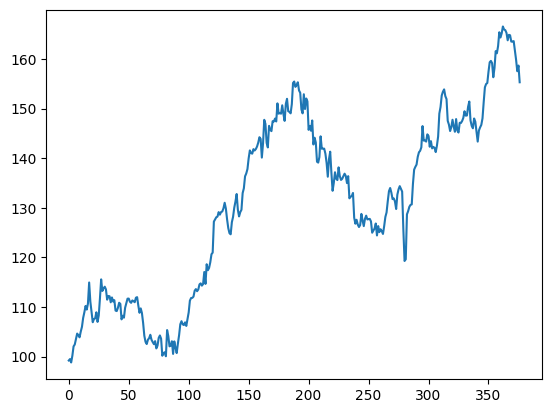

In [12]:
import numpy as np
state = pipeline.setup()
best_path = "./model_archive/tensorneat_extra_features/genomes/3.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

In [11]:
import yfinance as yf
import pandas as pd
import os

# Get the last date in merged_df
last_date = merged_df.index.max()
print(f"Last date in merged_df: {last_date}")


# Fetch historical data for all symbols in live_syms
for symbol in live_syms:
    print(f"Fetching data for {symbol}...")
    # Fetch data from the last date until now
    symbol_history = yf.download(symbol, start=last_date, progress=False)
    symbol_history.reset_index(inplace=True)
    symbol_history.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
    print(symbol_history.head())
    # Save the data to a CSV file
    output_path = f"hist_data/stocks/single/{symbol}_history.csv"
    symbol_history.to_csv(output_path, index=False)
    print(f"Saved {symbol} data to {output_path}")

Last date in merged_df: 2024-12-20
Fetching data for ABT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  111.540764  112.400044  109.871015  109.988192  12311900
1 2024-12-23  111.618874  111.814170  110.300657  111.316174   4028200
2 2024-12-24  112.058296  112.126648  110.915835  111.452890   1480000
3 2024-12-26  112.556282  113.083570  111.140421  111.511473   2960500
4 2024-12-27  112.282875  113.220274  111.814180  112.302408   2829500
Saved ABT data to hist_data/stocks/single/ABT_history.csv
Fetching data for ADM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  48.593876  49.055849  47.400442  47.544810  12132700
1 2024-12-23  48.516884  48.632376  47.766177  48.122281   2592200
2 2024-12-24  48.728619  48.795990  48.103028  48.516879   1434600
3 2024-12-26  48.709370  48.978853  48.391761  48.459132   1627600
4 2024-12-27  48.680496  49.267585  48.285890  48.391760   1537700
Saved ADM data to hist_data/stocks/single/ADM_history.csv
Fetching data for AES...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  12.104464  12.206886  11.508551  11.508551  25105700
1 2024-12-23  12.160330  12.188263  11.899618  12.002041  10108300
2 2024-12-24  12.123085  12.151018  11.992729  12.104462   3967400
3 2024-12-26  11.955485  12.095152  11.880996  12.067219   7272100
4 2024-12-27  11.871686  11.946175  11.713397  11.871686   9280700
Saved AES data to hist_data/stocks/single/AES_history.csv
Fetching data for AJG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  280.642944  283.953952  274.585958  277.093999  2774900
1 2024-12-23  282.040680  282.506602  278.382704  279.225333  1935200
2 2024-12-24  285.847351  285.996043  281.108839  282.744512  1045800
3 2024-12-26  285.857269  286.610683  283.696197  284.062981  1173300
4 2024-12-27  284.053070  286.491711  282.724704  285.341775  7622800
Saved AJG data to hist_data/stocks/single/AJG_history.csv
Fetching data for ALB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  86.847923  88.699503  85.740889  86.083780  3685400
1 2024-12-23  87.386734  88.033321  86.318895  87.220192  2003000
2 2024-12-24  88.160683  88.307635  86.191547  87.621868   595100
3 2024-12-26  87.337746  88.591724  86.661770  87.690428  1194900
4 2024-12-27  86.495247  89.003205  85.525374  86.838131  1397000
Saved ALB data to hist_data/stocks/single/ALB_history.csv
Fetching data for ALL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  189.833862  191.167682  183.802259  184.802613  2351800
1 2024-12-23  189.902512  190.108461  188.009657  188.843300  1336100
2 2024-12-24  191.756134  192.050362  189.206180  190.137888   453200
3 2024-12-26  191.854187  192.148415  190.775372  191.697278   563300
4 2024-12-27  190.069244  192.020926  188.882531  190.422315  1094400
Saved ALL data to hist_data/stocks/single/ALL_history.csv
Fetching data for AMP...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  525.389771  528.786264  514.459776  514.657258  1498700
1 2024-12-23  527.473145  527.650861  521.776163  523.089298   427100
2 2024-12-24  531.965637  533.061584  526.199474  530.089644   145100
3 2024-12-26  535.529907  536.151944  529.951344  529.951344   213700
4 2024-12-27  529.171387  536.941843  527.443520  533.604588   308300
Saved AMP data to hist_data/stocks/single/AMP_history.csv
Fetching data for A

C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  224.919998  226.210007  218.729996  219.839996  88279200
1 2024-12-23  225.059998  226.880005  223.899994  225.009995  28070000
2 2024-12-24  229.050003  229.139999  226.130005  226.940002  15007500
3 2024-12-26  227.050003  228.500000  226.669998  228.500000  16146700
4 2024-12-27  223.750000  226.029999  220.899994  225.600006  27367100
Saved AMZN data to hist_data/stocks/single/AMZN_history.csv
Fetching data for AOS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.002792  67.675553  66.369033  66.534784  2859700
1 2024-12-23  66.846794  66.963798  66.398290  66.515294   574400
2 2024-12-24  67.168541  67.168541  66.447035  66.768790   381800
3 2024-12-26  67.168541  67.509793  66.759038  66.924788   670600
4 2024-12-27  66.720047  67.344054  66.525048  66.885797   517900
Saved AOS data to hist_data/stocks/single/AOS_history.csv
Fetching data for APH...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  70.040947  70.636363  68.423391  68.780642  12193100
1 2024-12-23  70.447807  70.656203  69.574531  70.249338   2970600
2 2024-12-24  71.112701  71.172241  70.269187  70.467664   1660900
3 2024-12-26  71.013458  71.251631  70.537128  70.705828   2882700
4 2024-12-27  70.199722  70.884455  69.733311  70.457739   4072300
Saved APH data to hist_data/stocks/single/APH_history.csv
Fetching data for AXON...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  631.690002  633.210022  605.099976  607.950012  7032800
1 2024-12-23  624.140015  642.530029  616.969971  634.640015   626700
2 2024-12-24  631.250000  631.780029  619.070007  619.669983   260500
3 2024-12-26  623.799988  630.000000  620.960022  630.000000   525800
4 2024-12-27  610.979980  622.460022  606.549988  620.950012   392100
Saved AXON data to hist_data/stocks/single/AXON_history.csv
Fetching data for AXP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  294.812164  298.829870  288.247627  288.593135  6232400
1 2024-12-23  294.960266  295.907951  291.396671  292.670102  1902400
2 2024-12-24  299.560364  299.718311  294.170536  295.443967   862900
3 2024-12-26  300.083588  300.972046  297.141901  297.605863  1228900
4 2024-12-27  297.181335  301.169428  294.871409  296.983924  1676000
Saved AXP data to hist_data/stocks/single/AXP_history.csv
Fetching data for BAX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  28.975822  29.457116  28.651686  28.818666  12194900
1 2024-12-23  28.661510  29.015114  28.239151  28.779377   4988400
2 2024-12-24  28.563290  28.651691  28.357022  28.494534   1577900
3 2024-12-26  28.779377  28.916891  28.288261  28.484708   2534200
4 2024-12-27  28.681156  28.838313  28.504354  28.563288   2773300
Saved BAX data to hist_data/stocks/single/BAX_history.csv
Fetching data for BBY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  81.185165  81.555267  79.192303  79.543428  5213600
1 2024-12-23  80.966896  81.754550  80.217202  81.052308  2049200
2 2024-12-24  82.418839  82.418839  80.834045  81.004862  1025000
3 2024-12-26  84.810265  85.094954  82.001287  82.001287  2630100
4 2024-12-27  83.538628  84.506590  83.149550  84.259854  1773800
Saved BBY data to hist_data/stocks/single/BBY_history.csv
Fetching data for BDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  222.858582  224.454069  218.776888  219.217371  3104600
1 2024-12-23  221.644867  223.044578  220.529008  221.546979  1783700
2 2024-12-24  222.144058  222.320254  219.442510  221.918933   492300
3 2024-12-26  223.289291  224.346423  220.489855  221.537203  1154600
4 2024-12-27  223.651459  225.217568  221.918936  221.948300  1420900
Saved BDX data to hist_data/stocks/single/BDX_history.csv
Fetching data for BEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  19.038290  19.437825  18.527258  18.564423  9415800
1 2024-12-23  19.010416  19.159082  18.833879  18.973251  3446200
2 2024-12-24  19.400660  19.437826  18.973251  19.084750  1350900
3 2024-12-26  19.474991  19.577198  19.224122  19.233413  2262400
4 2024-12-27  19.196245  19.530740  19.159080  19.363493  2362500
Saved BEN data to hist_data/stocks/single/BEN_history.csv
Fetching data for BKR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  39.476105  39.613174  38.497035  38.555780  17974900
1 2024-12-23  39.309662  39.417356  38.849498  39.172589   4094300
2 2024-12-24  39.936272  40.043970  39.055107  39.348827   2122000
3 2024-12-26  40.024384  40.043965  39.427150  39.936267   2289600
4 2024-12-27  39.946060  40.259362  39.671922  39.857944   3282500
Saved BKR data to hist_data/stocks/single/BKR_history.csv
Fetching data for BK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  75.603340  75.992942  74.113085  74.902045  13075300
1 2024-12-23  75.554642  75.632565  74.824128  74.941013   2670000
2 2024-12-24  76.022171  76.265676  75.320876  75.564381   1236500
3 2024-12-26  76.314384  76.450747  75.554651  75.729975   1970200
4 2024-12-27  75.554642  76.421518  75.077375  75.885812   2072300
Saved BK data to hist_data/stocks/single/BK_history.csv
Fetching data for BLDR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  150.500000  150.919998  145.850006  146.000000  4308000
1 2024-12-23  149.029999  150.389999  147.009995  149.139999  1722800
2 2024-12-24  148.820007  149.979996  147.690002  149.000000   588800
3 2024-12-26  148.179993  148.800003  146.029999  147.750000   959800
4 2024-12-27  145.080002  148.490005  144.380005  147.520004  1160600
Saved BLDR data to hist_data/stocks/single/BLDR_history.csv
Fetching data for BRO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  102.034668  102.956579  101.023544  101.410151  2726000
1 2024-12-23  101.905800  102.044581  100.745971  101.489447   773000
2 2024-12-24  102.946663  103.035884  101.301106  101.638145   338300
3 2024-12-26  102.837616  102.976398  102.064402  102.064402   588000
4 2024-12-27  101.995026  102.986327  101.489460  102.302327   676500
Saved BRO data to hist_data/stocks/single/BRO_history.csv
Fetching data for BSX...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  88.949997  89.669998  87.250000  88.000000  15909900
1 2024-12-23  89.860001  89.989998  88.360001  89.269997   3833800
2 2024-12-24  91.070000  91.089996  89.660004  89.860001   1880000
3 2024-12-26  91.449997  91.550003  90.589996  90.680000   2601600
4 2024-12-27  90.660004  91.500000  90.230003  90.900002   3177600
Saved BSX data to hist_data/stocks/single/BSX_history.csv
Fetching data for BWA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  31.406279  31.563903  30.795493  30.795493  7655000
1 2024-12-23  31.524494  31.613157  31.140290  31.248654  1907500
2 2024-12-24  31.701820  31.751077  31.337318  31.514643   718100
3 2024-12-26  31.780628  31.928401  31.455534  31.632859  1210000
4 2024-12-27  31.711668  32.145132  31.406275  31.485086  1191700
Saved BWA data to hist_data/stocks/single/BWA_history.csv
Fetching data for CAT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  359.752899  365.109272  351.104030  352.342398  5142000
1 2024-12-23  359.114105  360.057608  355.290905  358.603018  1804900
2 2024-12-24  361.256653  361.256653  356.430983  358.190247   886000
3 2024-12-26  360.814392  361.178032  357.620214  358.779939  1097900
4 2024-12-27  358.593170  361.089552  355.536602  357.148448  1245800
Saved CAT data to hist_data/stocks/single/CAT_history.csv
Fetching data for CCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  26.799999  27.139999  25.440001  25.780001  61015000
1 2024-12-23  25.730000  26.540001  25.260000  26.520000  35169600
2 2024-12-24  25.790001  26.049999  25.420000  26.000000  10234900
3 2024-12-26  25.660000  25.830000  25.370001  25.480000  12363700
4 2024-12-27  25.080000  25.540001  24.889999  25.410000  14967400
Saved CCL data to hist_data/stocks/single/CCL_history.csv
Fetching data for CE...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.082375  68.431513  66.566111  66.615984  7876500
1 2024-12-23  69.030037  69.458981  67.982620  68.321782  2011600
2 2024-12-24  68.232010  69.239531  67.972646  69.000115  1487200
3 2024-12-26  68.980164  69.099864  67.892837  68.172148  1222100
4 2024-12-27  68.591118  69.967726  68.112293  68.670916  2000800


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved CE data to hist_data/stocks/single/CE_history.csv
Fetching data for CLX...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  156.754532  157.288357  155.305568  156.764059  4020600
1 2024-12-23  155.467606  156.354147  153.360903  156.335078   766100
2 2024-12-24  155.791748  155.896608  154.562045  155.381852   399400
3 2024-12-26  156.306503  156.706872  155.343713  155.381837   601100
4 2024-12-27  155.381836  156.725940  154.638292  155.772677   596100
Saved CLX data to hist_data/stocks/single/CLX_history.csv
Fetching data for CMCSA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  34.116108  34.196442  33.303819  33.553752  64062787
1 2024-12-23  33.901878  34.107181  33.625164  33.946509  17799054
2 2024-12-24  34.276779  34.294633  33.660866  33.785835   7995138
3 2024-12-26  34.142887  34.330340  34.000068  34.142887  11549742
4 2024-12-27  33.857246  34.142884  33.643016  33.776908  16425611
Saved CMCSA data to hist_data/stocks/single/CMCSA_history.csv
Fetching data for CME...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  228.395264  230.099633  225.589761  226.930272  3172400
1 2024-12-23  227.897339  228.443128  225.790816  227.887769  1620100
2 2024-12-24  229.295319  229.381491  227.906930  227.954808   478400
3 2024-12-26  229.046371  229.448525  228.117584  228.337808  1174700
4 2024-12-27  229.134705  230.410404  227.378175  227.378175  1384000
Saved CME data to hist_data/stocks/single/CME_history.csv
Fetching data for COF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  176.400238  178.582414  172.075406  172.875203  5164300
1 2024-12-23  177.703613  178.078833  174.938871  175.165970  2095300
2 2024-12-24  179.826523  179.945022  177.387627  177.565368   931300
3 2024-12-26  180.063538  180.438757  177.743125  178.483680  1255600
4 2024-12-27  177.950470  180.547355  177.219783  178.809509  1209100
Saved COF data to hist_data/stocks/single/COF_history.csv
Fetching data for CRM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  341.421082  344.202939  328.992242  330.581840  14932300
1 2024-12-23  340.675934  341.619784  334.496276  340.030156   5330300
2 2024-12-24  342.196014  342.712661  338.619358  340.775297   1811000
3 2024-12-26  339.503601  342.643109  338.818074  342.643109   3483300
4 2024-12-27  336.254852  340.050053  333.095454  338.142523   3220400
Saved CRM data to hist_data/stocks/single/CRM_history.csv
Fetching data for CSCO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  56.745182  56.997295  55.533093  55.823993  69544600
1 2024-12-23  57.191227  57.230015  56.357309  56.367008  18671200
2 2024-12-24  58.034843  58.034843  57.016689  57.016689   9922300
3 2024-12-26  58.160900  58.238476  57.598493  57.811818   8524500
4 2024-12-27  57.802124  58.199689  57.346377  57.763336  13021400
Saved CSCO data to hist_data/stocks/single/CSCO_history.csv
Fetching data for CSGP...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  71.440002  71.860001  69.610001  69.889999  7036000
1 2024-12-23  72.739998  72.860001  70.110001  70.120003  2637900
2 2024-12-24  72.949997  73.000000  71.930000  72.330002  1159700
3 2024-12-26  73.099998  73.519997  71.800003  72.379997  1293000
4 2024-12-27  72.220001  72.800003  71.690002  72.279999  1702400
Saved CSGP data to hist_data/stocks/single/CSGP_history.csv
Fetching data for CVX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  136.521301  136.521301  134.323196  134.581238  32209200
1 2024-12-23  136.635986  136.999156  135.269332  136.167690   8156500
2 2024-12-24  137.467422  137.658559  135.957420  136.760216   3556100
3 2024-12-26  137.601227  137.916609  136.569072  137.304963   4492600
4 2024-12-27  137.620346  139.254594  137.037370  137.897492   5296500
Saved CVX data to hist_data/stocks/single/CVX_history.csv
Fetching data for C...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  66.973160  68.008877  65.850323  66.101994  27720100
1 2024-12-23  67.534576  67.641053  66.663418  67.137717   8248000
2 2024-12-24  68.725174  68.928445  67.699139  67.854008   6544900
3 2024-12-26  69.063950  69.180107  68.250867  68.279904   6341700
4 2024-12-27  68.725174  69.238192  68.279913  68.589660   7743100
Saved C data to hist_data/stocks/single/C_history.csv
Fetching data for DE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  425.025391  428.966189  418.391893  418.657252  2446400
1 2024-12-23  424.917358  425.163044  419.630210  425.163044  1093900
2 2024-12-24  425.369385  426.106440  421.310662  423.177863   383200
3 2024-12-26  426.352142  427.934370  423.010831  424.337536   444900
4 2024-12-27  422.637329  427.659148  419.718589  424.868139   735300
Saved DE data to hist_data/stocks/single/DE_history.csv
Fetching data for DG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.170700  74.568733  71.636858  71.636858  5865400
1 2024-12-23  72.442627  73.568775  71.238804  73.355193  5089400
2 2024-12-24  72.462044  72.821250  71.957220  72.326129  1542300
3 2024-12-26  73.423164  73.607623  71.996064  72.568845  3600700
4 2024-12-27  73.675575  74.287190  72.996004  73.190165  2659700
Saved DG data to hist_data/stocks/single/DG_history.csv
Fetching data for DHI...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  137.577255  138.720369  135.300892  135.921709  7848000
1 2024-12-23  138.050262  138.148812  135.813325  137.232346  2410100
2 2024-12-24  138.996292  139.203226  137.074687  137.261908  1162200
3 2024-12-26  139.410187  140.277379  137.853190  137.961589  1677400
4 2024-12-27  138.237503  140.021147  137.656097  138.533138  1624300
Saved DHI data to hist_data/stocks/single/DHI_history.csv
Fetching data for DIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  110.804588  111.734309  109.222091  109.400122  17955300
1 2024-12-23  110.181488  110.626563  109.103407  110.389190   6037200
2 2024-12-24  111.328789  111.506820  109.973779  110.033120   2475000
3 2024-12-26  111.318909  112.080483  110.636454  110.893612   4781400
4 2024-12-27  110.329849  110.893614  109.647394  110.596893   4523800
Saved DIS data to hist_data/stocks/single/DIS_history.csv
Fetching data for DLR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  173.230240  176.043515  170.523661  171.522860  4801700
1 2024-12-23  173.133224  173.763782  171.270640  173.346647  2167100
2 2024-12-24  175.005508  175.005508  172.628774  173.036213   683700
3 2024-12-26  174.132416  174.607769  173.162319  173.831688   693500
4 2024-12-27  172.813080  174.248819  172.027304  172.890689   822900
Saved DLR data to hist_data/stocks/single/DLR_history.csv
Fetching data for DOV...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  187.169678  188.504688  185.419315  186.437884  2381100
1 2024-12-23  186.714798  187.337812  184.885336  186.269795   611000
2 2024-12-24  188.217926  188.415704  186.358783  186.358783   215500
3 2024-12-26  188.791473  189.365039  187.169673  187.377334   299000
4 2024-12-27  186.240097  189.365034  185.567635  187.209218   457400
Saved DOV data to hist_data/stocks/single/DOV_history.csv
Fetching data for DPZ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  419.487579  425.728017  417.351672  421.899118  932700
1 2024-12-23  419.841919  420.875418  413.847556  418.906825  332800
2 2024-12-24  424.231873  425.363808  418.148926  420.816362  214900
3 2024-12-26  425.826447  427.529291  421.603805  421.751474  300900
4 2024-12-27  422.873505  425.698431  421.200218  421.200218  291000
Saved DPZ data to hist_data/stocks/single/DPZ_history.csv
Fetching data for DTE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  116.255760  116.555635  112.889389  113.121558  3035900
1 2024-12-23  116.323463  116.478242  115.036890  116.129997   899000
2 2024-12-24  116.816818  116.865181  116.149346  116.149346   309900
3 2024-12-26  117.136040  117.387552  116.120330  116.323472   533400
4 2024-12-27  117.387550  118.093717  116.178367  116.458898  1074800
Saved DTE data to hist_data/stocks/single/DTE_history.csv
Fetching data for DXCM...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  80.040001  81.510002  75.470001  75.470001  11578500
1 2024-12-23  79.540001  80.250000  77.800003  78.900002   2389400
2 2024-12-24  80.239998  80.830002  78.589996  79.559998   1153100
3 2024-12-26  80.570000  80.669998  79.250000  79.540001   1350500
4 2024-12-27  80.239998  80.500000  79.629997  80.029999   1797800
Saved DXCM data to hist_data/stocks/single/DXCM_history.csv
Fetching data for EA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  147.095718  148.946856  146.000954  146.379148  4055500
1 2024-12-23  146.598083  146.916551  145.801893  146.916551  1708600
2 2024-12-24  148.469116  148.936878  146.309459  146.707562   778600
3 2024-12-26  148.359665  148.777662  147.244992  147.633133   883400
4 2024-12-27  147.414169  148.140702  146.329367  147.752561  1023500
Saved EA data to hist_data/stocks/single/EA_history.csv
Fetching data for ED...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.026680  87.510000  85.818379  85.818379  4876400
1 2024-12-23  86.678688  86.891350  85.828047  86.891350  1979000
2 2024-12-24  86.591698  86.736695  86.127707  86.417702   653900
3 2024-12-26  86.601357  87.123343  86.031042  86.253373  1879800
4 2024-12-27  86.572357  86.959015  85.866713  86.031041  1319600
Saved ED data to hist_data/stocks/single/ED_history.csv
Fetching data for EFX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  256.398407  260.872962  252.578682  252.896158  1788100
1 2024-12-23  256.457947  257.261577  253.670039  255.366618   480400
2 2024-12-24  259.216095  259.523656  252.201681  255.366622   208700
3 2024-12-26  256.765503  259.940359  256.279365  256.299196   432500
4 2024-12-27  253.967667  257.013525  252.677883  254.354600   406600
Saved EFX data to hist_data/stocks/single/EFX_history.csv
Fetching data for EIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.027359  74.157695  72.416858  72.491334  5974300
1 2024-12-23  74.213547  74.222858  73.040576  74.027357  1959100
2 2024-12-24  74.716255  74.753493  73.934272  74.381121   997100
3 2024-12-26  74.483528  74.688333  74.055302  74.334576  1000200
4 2024-12-27  74.278717  74.781419  73.915656  73.962198   985500
Saved EIX data to hist_data/stocks/single/EIX_history.csv
Fetching data for EL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  73.071259  74.240637  72.688018  72.717497  7621000
1 2024-12-23  73.454498  74.063756  72.363735  72.648710  2995200
2 2024-12-24  73.778778  73.985138  72.186852  73.474146  1162700
3 2024-12-26  73.700165  74.574739  73.218659  73.582242  1740500
4 2024-12-27  73.326752  73.916352  72.412869  72.835417  1853400
Saved EL data to hist_data/stocks/single/EL_history.csv
Fetching data for EMN...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.705063  88.096941  84.952327  85.382446  2504100
1 2024-12-23  87.179367  88.049157  86.290464  87.294067  1175500
2 2024-12-24  87.523460  87.666833  86.806603  87.102902   309200
3 2024-12-26  87.466118  87.848443  86.902187  86.988213   695100
4 2024-12-27  87.685936  88.603512  87.188918  87.236704  1104100
Saved EMN data to hist_data/stocks/single/EMN_history.csv
Fetching data for EQIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  906.432068  915.474687  898.679862  901.935222  1434600
1 2024-12-23  918.524841  921.144750  902.316541  911.427598   488700
2 2024-12-24  928.711243  928.711243  916.677229  918.524871   168400
3 2024-12-26  927.127563  930.881439  921.858390  927.987839   234800
4 2024-12-27  921.526001  928.867640  918.446658  918.827929   289700
Saved EQIX data to hist_data/stocks/single/EQIX_history.csv
Fetching data for EQR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.799767  68.531457  66.459929  67.011064  5177000
1 2024-12-23  67.885300  68.046839  67.001574  67.229630  1300900
2 2024-12-24  68.626480  68.740505  67.533700  67.676238   568700
3 2024-12-26  68.769020  68.940064  68.227382  68.464943   747200
4 2024-12-27  68.018333  69.044597  67.856794  68.151367   946100
Saved EQR data to hist_data/stocks/single/EQR_history.csv
Fetching data for EQT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  42.479664  43.121945  41.916427  42.084411  12908800
1 2024-12-23  43.339340  43.477678  42.341328  42.489549   4813900
2 2024-12-24  44.050789  44.228649  43.112066  43.566604   2013600
3 2024-12-26  43.655537  44.110075  43.191115  43.635774   2712300
4 2024-12-27  43.793877  44.446042  43.438150  43.645656   4508300
Saved EQT data to hist_data/stocks/single/EQT_history.csv
Fetching data for ESS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  271.092102  274.426289  267.796109  267.901213  1417600
1 2024-12-23  271.636658  272.219441  268.550873  269.706847   386400
2 2024-12-24  273.986847  274.005944  269.668615  271.894613   121600
3 2024-12-26  274.865753  276.289255  272.955039  273.404058   231600
4 2024-12-27  271.732147  275.668213  270.776790  273.136523   298700
Saved ESS data to hist_data/stocks/single/ESS_history.csv
Fetching data for EXPE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  183.270676  184.034514  175.959693  175.959693  4134800
1 2024-12-23  187.327911  187.952872  181.911639  184.748739  1461500
2 2024-12-24  188.161179  188.716707  186.742636  187.744543   366200
3 2024-12-26  188.597656  188.766293  186.990633  188.200865   879500
4 2024-12-27  184.619781  188.577838  183.221068  186.306166  1395000
Saved EXPE data to hist_data/stocks/single/EXPE_history.csv
Fetching data for FAST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  36.430222  36.600638  35.748554  35.836197  15509000
1 2024-12-23  36.264683  36.478918  36.016360  36.362062   4135000
2 2024-12-24  36.571430  36.586037  36.152692  36.342584   2134600
3 2024-12-26  36.235462  36.444831  36.181902  36.332845   2531800
4 2024-12-27  35.553795  36.001750  35.217833  35.982274   5252600
Saved FAST data to hist_data/stocks/single/FAST_history.csv
Fetching data for FCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  38.181255  38.603745  37.296974  37.316625  22372300
1 2024-12-23  38.564438  38.652866  37.886491  38.240200   8562500
2 2024-12-24  38.534969  38.701998  38.132131  38.682347   3962500
3 2024-12-26  38.505489  38.633220  38.240205  38.358112   6127100
4 2024-12-27  38.181255  38.495666  37.886496  38.220558   7892500
Saved FCX data to hist_data/stocks/single/FCX_history.csv
Fetching data for FDS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  477.962708  480.097885  464.924303  479.020417  922800
1 2024-12-23  483.715790  484.200148  474.502902  474.502902  264300
2 2024-12-24  485.702759  486.345282  482.094715  484.259547  110700
3 2024-12-26  485.959717  487.294207  481.827766  482.163855  163900
4 2024-12-27  480.967773  487.333758  477.300422  484.526403  155200
Saved FDS data to hist_data/stocks/single/FDS_history.csv
Fetching data for FDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  269.356720  288.415741  264.638345  287.204412  8126800
1 2024-12-23  262.792084  268.751064  258.962678  268.643621  3500700
2 2024-12-24  265.556671  266.230725  261.414684  262.782319  1013100
3 2024-12-26  272.219025  273.821102  264.052243  264.101105  1777300
4 2024-12-27  273.879700  275.091058  270.148018  270.919737  1553200
Saved FDX data to hist_data/stocks/single/FDX_history.csv
Fetching data for FFIV...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  252.250000  254.009995  248.020004  249.259995  1233800
1 2024-12-23  254.410004  254.809998  250.880005  251.750000   269700
2 2024-12-24  256.200012  257.040009  253.899994  253.990005   172600
3 2024-12-26  257.119995  257.899994  254.699997  255.630005   204200
4 2024-12-27  255.630005  256.869995  253.669998  254.110001   212200
Saved FFIV data to hist_data/stocks/single/FFIV_history.csv
Fetching data for FRT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  105.896599  107.003629  103.881235  103.881235  1825000
1 2024-12-23  106.095299  106.303460  105.045037  105.480287   480200
2 2024-12-24  106.663010  106.823859  105.745213  105.745213   210100
3 2024-12-26  106.719772  107.041470  105.508662  106.085833   269500
4 2024-12-27  105.432968  106.918472  105.073422  106.180452   383300
Saved FRT data to hist_data/stocks/single/FRT_history.csv
Fetching data for FSLR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  182.389999  183.009995  173.360001  174.460007  3462900
1 2024-12-23  186.360001  186.830002  180.520004  183.399994  1718400
2 2024-12-24  186.210007  189.139999  184.500000  186.839996   671900
3 2024-12-26  183.710007  186.500000  183.240005  184.509995   732000
4 2024-12-27  182.630005  184.740005  180.520004  184.039993  1034100
Saved FSLR data to hist_data/stocks/single/FSLR_history.csv
Fetching data fo

C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  97.190002  97.830002  93.360001  93.720001  13324400
1 2024-12-23  96.419998  97.070000  95.339996  96.930000   3107900
2 2024-12-24  97.809998  97.830002  96.320000  96.650002   1764900
3 2024-12-26  97.290001  97.599998  96.730003  97.160004   1661500
4 2024-12-27  96.080002  96.510002  94.800003  96.510002   2774700
Saved FTNT data to hist_data/stocks/single/FTNT_history.csv
Fetching data for GIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  59.982204  60.821446  59.718175  60.642279  10672900
1 2024-12-23  59.925621  60.246230  59.397561  59.557864   3380200
2 2024-12-24  60.104794  60.189661  59.576730  59.595590   1220400
3 2024-12-26  60.123646  60.689429  59.850188  59.878476   2212100
4 2024-12-27  60.302814  60.519697  59.878478  59.982205   1984400
Saved GIS data to hist_data/stocks/single/GIS_history.csv
Fetching data for GLW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  46.427635  46.427635  45.671996  45.829012  11445800
1 2024-12-23  46.614086  46.682780  46.152851  46.398188   2852200
2 2024-12-24  47.006634  47.006634  46.162673  46.466889   1592800
3 2024-12-26  47.094952  47.153830  46.574834  46.722038   1960200
4 2024-12-27  46.888866  47.173459  46.565023  46.722039   2255000
Saved GLW data to hist_data/stocks/single/GLW_history.csv
Fetching data for GOOG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  192.211700  193.382132  185.647245  186.284763  45319700
1 2024-12-23  195.229950  195.728011  190.886858  193.277544  15235900
2 2024-12-24  196.803848  196.903451  194.441037  195.409268   6809800
3 2024-12-26  196.335663  197.391550  195.110422  195.977058   7907900
4 2024-12-27  193.287506  196.036813  191.227533  195.708090  14693000
Saved GOOG data to hist_data/stocks/single/GOOG_history.csv
Fetching data for GPN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  110.709244  111.519576  108.120137  108.396834  3300500
1 2024-12-23  110.491844  110.748781  108.298015  109.622221  1053900
2 2024-12-24  111.648048  111.875333  110.145964  110.145964   439200
3 2024-12-26  112.418854  112.735081  110.412787  110.867363   821200
4 2024-12-27  111.025475  112.833902  110.570899  111.489935  1038600
Saved GPN data to hist_data/stocks/single/GPN_history.csv
Fetching data for HIG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  107.652176  107.957026  104.347970  104.879004  5819000
1 2024-12-23  107.898026  108.075037  106.826122  107.022805  1095600
2 2024-12-24  108.733910  108.753574  107.445665  107.888190   397800
3 2024-12-26  109.137100  109.235438  108.173371  108.517557   574200
4 2024-12-27  108.281548  109.559963  107.957026  108.242211   856000
Saved HIG data to hist_data/stocks/single/HIG_history.csv
Fetching data for HRL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  30.016279  30.215250  29.864682  29.978379  4859800
1 2024-12-23  29.893103  30.044700  29.694132  29.826779  1845800
2 2024-12-24  29.949955  30.092077  29.703609  29.836256   844000
3 2024-12-26  30.016279  30.101553  29.732033  29.798358  1253000
4 2024-12-27  30.177349  30.319471  29.826779  29.826779  1718600
Saved HRL data to hist_data/stocks/single/HRL_history.csv
Fetching data for HSIC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  69.820000  70.330002  68.430000  68.949997  2761500
1 2024-12-23  70.059998  70.750000  69.459999  69.589996  1111900
2 2024-12-24  70.010002  70.239998  69.440002  69.949997   421000
3 2024-12-26  70.970001  72.540001  69.760002  70.000000   851500
4 2024-12-27  70.419998  71.129997  69.839996  70.269997   501200
Saved HSIC data to hist_data/stocks/single/HSIC_history.csv
Fetching data for HST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  16.888893  17.037367  16.127964  16.174363  19799300
1 2024-12-23  16.768259  16.898173  16.619785  16.870335   4286000
2 2024-12-24  16.907452  16.953851  16.712581  16.786817   1710000
3 2024-12-26  16.963131  17.018808  16.786818  16.879614   3034500
4 2024-12-27  16.684738  16.926008  16.545544  16.833212   7022200
Saved HST data to hist_data/stocks/single/HST_history.csv
Fetching data for ICE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  148.626511  149.644973  146.342385  146.688471  6446800
1 2024-12-23  148.478195  148.735278  147.103764  147.716815  2853800
2 2024-12-24  148.774857  148.883625  147.924488  148.478214  1084600
3 2024-12-26  149.328583  149.674654  147.528959  147.528959  1168100
4 2024-12-27  148.636414  149.654876  147.855253  148.201339  1212400
Saved ICE data to hist_data/stocks/single/ICE_history.csv
Fetching data for IEX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  208.450256  209.598606  203.140356  205.623541  1243600
1 2024-12-23  206.860229  208.597483  206.516715  207.174316   424000
2 2024-12-24  208.352097  208.764323  206.281138  206.281138   156300
3 2024-12-26  209.039154  210.393624  207.380422  207.959517   401800
4 2024-12-27  207.203766  209.480830  206.310600  207.360809   166100
Saved IEX data to hist_data/stocks/single/IEX_history.csv
Fetching data for IFF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  83.779778  84.835088  82.812413  83.300982  4203000
1 2024-12-23  82.851494  83.652746  81.932982  83.515948  1334600
2 2024-12-24  83.164177  83.574573  82.792867  83.056691   378400
3 2024-12-26  82.988297  83.486639  82.675613  82.802638   592600
4 2024-12-27  82.656059  83.369373  82.323836  82.372696   740700
Saved IFF data to hist_data/stocks/single/IFF_history.csv
Fetching data for INCY...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.839996  69.110001  66.889999  66.889999  6805500
1 2024-12-23  69.839996  70.190002  68.150002  68.580002  1611100
2 2024-12-24  69.910004  70.099998  68.919998  69.879997   395900
3 2024-12-26  69.559998  70.110001  69.250000  69.519997   764500
4 2024-12-27  69.230003  69.900002  68.190002  68.709999   966400
Saved INCY data to hist_data/stocks/single/INCY_history.csv
Fetching data for IP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  52.316490  52.354924  51.413320  51.567050  6737000
1 2024-12-23  52.354927  52.354927  51.259592  51.932165  2549000
2 2024-12-24  52.950634  52.989068  52.460615  52.700819   879400
3 2024-12-26  53.046711  53.181225  52.739250  52.941021  1743000
4 2024-12-27  52.354927  52.998673  52.143546  52.844942  1681200
Saved IP data to hist_data/stocks/single/IP_history.csv
Fetching data for IRM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  101.441200  103.255757   98.941368   99.037886  5696100
1 2024-12-23  101.557030  101.672848   98.680768  100.852440  2095900
2 2024-12-24  101.904503  101.904503  100.485676  101.238521   767700
3 2024-12-26  102.049271  102.290567  100.543573  101.489460   879900
4 2024-12-27  101.074432  102.029966  100.408451  100.977915   954200
Saved IRM data to hist_data/stocks/single/IRM_history.csv
Fetching data for ISRG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  524.429993  530.969971  516.179993  521.450012  3933900
1 2024-12-23  527.219971  527.940002  520.030029  524.880005  1069800
2 2024-12-24  537.020020  537.359985  527.260010  528.010010   629200
3 2024-12-26  538.830017  540.130005  533.989990  534.859985   765700
4 2024-12-27  534.880005  537.340027  529.309998  536.010010  1013200
Saved ISRG data to hist_data/stocks/single/ISRG_history.csv
Fetching data for JBHT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  167.937469  169.071991  163.271174  166.240632  2140300
1 2024-12-23  168.243286  168.578719  166.270221  167.355413   513300
2 2024-12-24  169.259430  169.367934  167.394869  167.789491   180900
3 2024-12-26  169.693481  170.147293  167.986784  168.411001   268000
4 2024-12-27  169.693481  170.768814  167.769746  169.052241   298300
Saved JBHT data to hist_data/stocks/single/JBHT_history.csv
Fetching data for JCI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  79.621841  80.006917  77.281762  77.607597  6394200
1 2024-12-23  79.661514  80.068207  78.897735  79.195308  4021000
2 2024-12-24  80.336014  80.336014  79.334175  79.403609  1241100
3 2024-12-26  80.197151  80.623679  79.849979  80.107882  1348600
4 2024-12-27  79.175468  80.147558  78.858053  79.135791  1651800
Saved JCI data to hist_data/stocks/single/JCI_history.csv
Fetching data for KIM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  22.329638  22.510792  21.938726  21.967330  9672400
1 2024-12-23  22.339172  22.415448  22.129414  22.234293  3739800
2 2024-12-24  22.520327  22.558463  22.215223  22.234293  1557400
3 2024-12-26  22.510792  22.625204  22.377309  22.396378  1580800
4 2024-12-27  22.281967  22.606136  22.205692  22.405914  2023500
Saved KIM data to hist_data/stocks/single/KIM_history.csv
Fetching data for KMX...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  84.269997  85.400002  82.120003  85.400002  4192700
1 2024-12-23  83.699997  84.199997  82.529999  84.110001  1864100
2 2024-12-24  84.910004  85.199997  83.629997  84.000000   901600
3 2024-12-26  85.169998  85.540001  83.790001  84.230003  1160300
4 2024-12-27  83.769997  85.309998  83.269997  84.099998  1319900


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved KMX data to hist_data/stocks/single/KMX_history.csv
Fetching data for K...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  78.269234  78.740794  78.103946  78.113664  5307417
1 2024-12-23  78.463692  78.483142  78.220620  78.220620  1228725
2 2024-12-24  78.580360  78.638695  78.337288  78.337288   577930
3 2024-12-26  78.862335  78.881778  78.492868  78.512311   909371
4 2024-12-27  78.920654  79.037332  78.697032  78.784535   921988
Saved K data to hist_data/stocks/single/K_history.csv
Fetching data for LEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  130.842133  132.557245  129.411284  130.662093  9358257
1 2024-12-23  130.766342  131.979258  130.017760  130.387309  3821997
2 2024-12-24  130.766342  132.007682  130.283085  130.283085  2198947
3 2024-12-26  131.372772  132.187701  129.648175  129.818746  2752945
4 2024-12-27  129.998795  132.320373  129.449191  130.766331  2101122
Saved LEN data to hist_data/stocks/single/LEN_history.csv
Fetching data for LH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  226.101746  227.249022  224.074235  225.350090  996900
1 2024-12-23  225.340179  226.081951  222.778600  225.448973  510600
2 2024-12-24  226.972092  227.585284  223.233566  224.657754  144100
3 2024-12-26  228.524857  229.147949  226.497346  226.517131  430800
4 2024-12-27  227.901749  229.860035  226.536900  227.288556  339800
Saved LH data to hist_data/stocks/single/LH_history.csv
Fetching data for LKQ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  35.649483  36.065136  34.711846  34.992171  6251000
1 2024-12-23  35.639812  35.833140  35.088831  35.552815  1566500
2 2024-12-24  35.475487  35.697812  35.427156  35.697812  1320300
3 2024-12-26  35.765480  35.833144  35.282163  35.514157  1294500
4 2024-12-27  35.659145  35.929802  35.417487  35.485151  1193800
Saved LKQ data to hist_data/stocks/single/LKQ_history.csv
Fetching data for LRCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  71.138519  72.803274  69.662043  69.899863  29404500
1 2024-12-23  73.130280  73.318550  71.346611  71.693434  10406700
2 2024-12-24  73.160004  73.496915  72.565450  73.397824   5611700
3 2024-12-26  73.318535  73.883362  72.337521  72.585253   6297400
4 2024-12-27  72.733902  73.090636  71.980797  72.634811   5444100
Saved LRCX data to hist_data/stocks/single/LRCX_history.csv
Fetching data for MCD...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  286.008911  289.350972  282.705947  282.920934  7678000
1 2024-12-23  284.650635  286.419377  283.126194  285.598527  2492200
2 2024-12-24  287.289062  287.562679  284.162018  284.640840  1461000
3 2024-12-26  288.080597  288.706024  285.930760  286.321636  1433900
4 2024-12-27  286.927521  289.722348  286.067574  286.653904  1617200
Saved MCD data to hist_data/stocks/single/MCD_history.csv
Fetching data for MO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.280891  49.317505  48.374722  48.438794  27063800
1 2024-12-23  49.042912  49.290045  48.466258  49.280894   7199600
2 2024-12-24  48.942226  49.097829  48.868999  49.079522   5406800
3 2024-12-26  49.082188  49.250150  48.484990  48.783589   5230800
4 2024-12-27  48.876900  49.315464  48.615623  48.839574   6425500
Saved MO data to hist_data/stocks/single/MO_history.csv
Fetching data for MRK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  94.497444  96.068383  94.352877  95.249182  29289700
1 2024-12-23  95.769623  95.981646  94.642009  95.499762   8460500
2 2024-12-24  95.846718  96.029836  95.220275  95.625055   3713500
3 2024-12-26  96.251503  96.318966  95.335919  95.499758   4760300
4 2024-12-27  96.087654  96.714105  95.644322  95.894903   6173600
Saved MRK data to hist_data/stocks/single/MRK_history.csv
Fetching data for MSFT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  433.402924  440.490624  425.491284  429.938459  64263700
1 2024-12-23  432.062744  434.445163  429.660452  433.541823  19152500
2 2024-12-24  436.112854  436.380896  431.010509  431.467132   7164500
3 2024-12-26  434.901825  437.711119  433.432682  435.864723   8194200
4 2024-12-27  427.377319  432.032978  423.227936  431.417523  18117700
Saved MSFT data to hist_data/stocks/single/MSFT_history.csv
Fetching data for MSI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  464.861115  467.462696  455.028539  456.047406  2508300
1 2024-12-23  464.692871  465.167694  458.589571  463.871855   652500
2 2024-12-24  467.343964  467.353835  463.228920  464.880854   235400
3 2024-12-26  466.216309  466.977976  463.683978  465.375489   292300
4 2024-12-27  462.279266  465.533718  460.538308  463.357513   364800
Saved MSI data to hist_data/stocks/single/MSI_history.csv
Fetching data for MTD...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date        Close         High          Low         Open  Volume
0 2024-12-20  1230.739990  1240.660034  1197.119995  1206.069946  275200
1 2024-12-23  1234.390015  1236.329956  1219.150024  1219.439941   87700
2 2024-12-24  1246.300049  1248.199951  1229.770020  1233.770020   33600
3 2024-12-26  1245.280029  1247.020020  1234.430054  1234.430054   45200
4 2024-12-27  1234.229980  1245.760010  1228.869995  1231.359985   70700
Saved MTD data to hist_data/stocks/single/MTD_history.csv
Fetching data for NDAQ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  76.753380  77.622664  76.150811  76.437279  7181700
1 2024-12-23  76.990471  77.257178  76.269361  76.615096  1775300
2 2024-12-24  77.958519  77.998033  76.743508  77.049729   846400
3 2024-12-26  78.156090  78.432677  77.425100  77.543640  1842400
4 2024-12-27  77.464615  78.215358  77.109000  77.672056  1347000
Saved NDAQ data to hist_data/stocks/single/NDAQ_history.csv
Fetching data for NFLX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  90.904999  91.991997  89.049004  89.320999  45305000
1 2024-12-23  91.144997  91.500000  89.910004  91.342003  23394000
2 2024-12-24  93.211998  93.584999  91.169998  91.500000  23203000
3 2024-12-26  92.414001  93.049004  91.529999  92.839996  23403000
4 2024-12-27  90.754997  91.813004  89.449997  91.600998  32262000
Saved NFLX data to hist_data/stocks/single/NFLX_history.csv
Fetching data for NTAP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  115.532394  116.868652  112.264911  113.084225  3813600
1 2024-12-23  115.171524  115.776248  114.157140  115.347091  1457000
2 2024-12-24  115.912788  115.932300  114.654570  115.093482   441300
3 2024-12-26  115.434860  116.312693  114.547279  115.581167   733800
4 2024-12-27  114.079102  114.849644  112.781860  114.186393   995000
Saved NTAP data to hist_data/stocks/single/NTAP_history.csv
Fetching data for NVDA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open     Volume
0 2024-12-20  134.663162  135.243005  128.184939  129.774500  306528600
1 2024-12-23  139.631805  139.751768  135.083047  136.242733  176053500
2 2024-12-24  140.181671  141.861205  138.612093  139.961730  105157000
3 2024-12-26  139.891739  140.811501  137.692343  139.661806  116205600
4 2024-12-27  136.972534  138.981994  134.673175  138.512122  170582600
Saved NVDA data to hist_data/stocks/single/NVDA_history.csv
Fetching data for OMC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  85.643127  86.558733  83.773356  84.457652  6003400
1 2024-12-23  83.561317  85.392536  83.426386  85.238332  1809200
2 2024-12-24  83.262543  83.628783  82.857749  83.628783   823500
3 2024-12-26  84.264900  84.467297  82.597526  82.771010  1218300
4 2024-12-27  83.358925  84.380556  83.098703  83.570962  1164200
Saved OMC data to hist_data/stocks/single/OMC_history.csv
Fetching data for ON...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  65.500000  66.860001  63.939999  64.220001  12758500
1 2024-12-23  66.629997  66.989998  65.449997  65.500000   5257400
2 2024-12-24  67.900002  67.919998  66.419998  66.629997   3044800
3 2024-12-26  67.019997  67.949997  66.989998  67.050003   3659500
4 2024-12-27  66.010002  67.050003  65.480003  66.699997   4751900


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved ON data to hist_data/stocks/single/ON_history.csv
Fetching data for ORCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  167.546249  169.126306  163.566459  165.640287  13810500
1 2024-12-23  167.032715  167.506730  165.087258  167.477105   6518200
2 2024-12-24  169.274445  169.629960  166.924092  167.585742   2451500
3 2024-12-26  169.541077  170.400248  168.375785  168.375785   4100100
4 2024-12-27  166.854965  169.017668  165.116883  168.257272   4344300
Saved ORCL data to hist_data/stocks/single/ORCL_history.csv
Fetching data for O...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.432659  50.153689  48.692901  48.692901  14467200
1 2024-12-23  49.629299  49.694847  49.104913  49.348379   5474900
2 2024-12-24  49.854034  49.854034  49.320282  49.516929   2585000
3 2024-12-26  49.694851  49.994499  49.526298  49.732308   7385900
4 2024-12-27  49.310921  50.078770  49.133006  49.563750   5373900
Saved O data to hist_data/stocks/single/O_history.csv
Fetching data for PAYX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  133.904800  134.451789  131.064345  131.064345  4925600
1 2024-12-23  133.712906  133.952810  132.407827  133.549773  1514700
2 2024-12-24  135.680130  135.977609  133.482615  133.722519   885800
3 2024-12-26  136.879639  137.100346  135.113949  135.373049  2364200
4 2024-12-27  135.564972  137.205907  134.931622  136.361455  2032100
Saved PAYX data to hist_data/stocks/single/PAYX_history.csv
Fetching data for PEG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  82.402222  82.518475  79.563772  79.796278  5833000
1 2024-12-23  82.566917  82.605661  81.181599  82.392541  1953600
2 2024-12-24  83.109413  83.157846  82.285974  82.431281   600800
3 2024-12-26  82.731606  83.051296  82.150355  82.818790   943300
4 2024-12-27  82.276291  82.479728  81.578787  82.072853  1356000
Saved PEG data to hist_data/stocks/single/PEG_history.csv
Fetching data for PEP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  146.918915  147.592028  144.726527  145.063084  19205200
1 2024-12-23  145.476532  146.553505  143.957258  146.553505   6822200
2 2024-12-24  146.938126  146.957361  144.630354  144.716892   3399800
3 2024-12-26  146.582367  147.293922  146.390055  146.668905   5528500
4 2024-12-27  147.015076  147.572790  145.447705  145.476551   4287000
Saved PEP data to hist_data/stocks/single/PEP_history.csv
Fetching data for PFG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.411415  74.661694  71.735293  71.995208  3446700
1 2024-12-23  74.507668  74.603929  73.660547  73.930090   900100
2 2024-12-24  74.892723  75.027491  74.064860  74.276640   271200
3 2024-12-26  75.412544  75.470307  74.555803  74.806089   372400
4 2024-12-27  74.806091  75.720596  74.469172  74.844597   726800
Saved PFG data to hist_data/stocks/single/PFG_history.csv
Fetching data for PGR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  221.123077  224.246831  218.294184  219.280155  5587400
1 2024-12-23  222.081375  222.551329  219.740870  220.865054  1847300
2 2024-12-24  224.136261  224.145471  221.473238  222.320981   680200
3 2024-12-26  224.090179  224.873413  222.855425  224.366621   952300
4 2024-12-27  222.090622  224.357409  221.187580  222.661923  1410400
Saved PGR data to hist_data/stocks/single/PGR_history.csv
Fetching data for PHM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  109.643700  110.298470  107.709164  108.304405  4865700
1 2024-12-23  109.256790  109.703227  108.135753  109.078217  1477300
2 2024-12-24  109.871887  109.951255  108.740927  108.988944   700900
3 2024-12-26  109.772690  110.229042  108.512755  108.949269  1259000
4 2024-12-27  108.651627  110.229024  108.066308  108.859968   990600
Saved PHM data to hist_data/stocks/single/PHM_history.csv
Fetching data for PH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  639.758362  644.404332  625.059345  627.589907  1338500
1 2024-12-23  638.226135  640.193244  632.255546  635.181533   599400
2 2024-12-24  645.066467  645.234496  633.560295  636.792714   227000
3 2024-12-26  643.929749  644.364692  639.046548  642.269073   256900
4 2024-12-27  636.407227  643.277325  630.219197  638.572048   392500
Saved PH data to hist_data/stocks/single/PH_history.csv
Fetching data for PKG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  222.360275  223.199077  220.214508  220.575383  1955900
1 2024-12-23  221.482483  222.399314  219.746361  221.189875   630700
2 2024-12-24  223.179581  223.462426  221.141088  222.331016   513100
3 2024-12-26  223.794052  224.184201  222.370049  222.769932   661400
4 2024-12-27  221.492218  223.930593  220.760706  222.360279   894100
Saved PKG data to hist_data/stocks/single/PKG_history.csv
Fetching data for PM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  118.663132  119.188524  116.743045  117.020073  10267400
1 2024-12-23  118.242813  118.433871  116.599755  118.185499   3697100
2 2024-12-24  117.411743  118.548505  117.077394  117.956244   2806600
3 2024-12-26  117.556618  118.145802  117.064020  117.344124   2425600
4 2024-12-27  117.305489  117.817408  116.774262  117.498668   3923500
Saved PM data to hist_data/stocks/single/PM_history.csv
Fetching data for PNC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  184.464005  185.095603  180.865832  181.143345  3961400
1 2024-12-23  184.808517  184.980778  182.167307  183.019003  1493600
2 2024-12-24  185.727203  185.889885  183.679305  185.220015   724300
3 2024-12-26  186.387512  186.511907  183.908969  185.153023   746600
4 2024-12-27  184.961639  187.114804  183.937698  185.287003   886400
Saved PNC data to hist_data/stocks/single/PNC_history.csv
Fetching data for PNW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  80.823509  81.489432  79.995865  80.252723  1900600
1 2024-12-23  80.861565  81.185007  80.033920  80.775950  1087800
2 2024-12-24  81.441864  81.670177  80.785456  81.089876   359400
3 2024-12-26  81.280144  81.613102  80.709350  81.042316   798100
4 2024-12-27  80.813988  81.622609  80.623728  80.642751   642600
Saved PNW data to hist_data/stocks/single/PNW_history.csv
Fetching data for PODD...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  266.570007  270.700012  256.559998  256.559998  1466000
1 2024-12-23  263.329987  266.440002  258.970001  264.820007   493700
2 2024-12-24  263.230011  264.170013  261.540009  263.910004   140100
3 2024-12-26  265.679993  266.420013  261.260010  261.260010   244000
4 2024-12-27  265.119995  266.589996  262.269989  262.609985   312900
Saved PODD data to hist_data/stocks/single/PODD_history.csv
Fetching data for PPG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  117.115173  118.644753  115.527141  116.189634  3884400
1 2024-12-23  117.056732  117.319778  115.770716  116.861877  1470800
2 2024-12-24  117.865364  118.108928  116.481916  116.988533   539000
3 2024-12-26  118.108925  118.245320  116.959304  116.978786  1021600
4 2024-12-27  117.280800  118.790898  116.852133  117.319771   993100
Saved PPG data to hist_data/stocks/single/PPG_history.csv
Fetching data for PPL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  31.411627  31.440684  30.849840  30.869213  10037100
1 2024-12-23  31.392252  31.450369  31.101673  31.266333   3014800
2 2024-12-24  31.576288  31.595661  31.305082  31.392256    964200
3 2024-12-26  31.595657  31.653775  31.411625  31.556916   1636400
4 2024-12-27  31.498800  31.721577  31.314768  31.382570   2271200
Saved PPL data to hist_data/stocks/single/PPL_history.csv
Fetching data for PWR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  327.930573  330.436918  318.853846  319.113446  2080900
1 2024-12-23  326.902100  327.950555  323.067709  326.862149   595300
2 2024-12-24  330.327057  330.327057  326.802211  329.328517  1196900
3 2024-12-26  330.137329  330.886234  326.233034  329.688004   294500
4 2024-12-27  322.668274  328.909150  319.922289  327.670939   582000
Saved PWR data to hist_data/stocks/single/PWR_history.csv
Fetching data for RF...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  22.780523  22.905111  22.052160  22.071328  29520600
1 2024-12-23  22.847609  22.924278  22.569680  22.665517   5356700
2 2024-12-24  23.020119  23.020119  22.684688  22.809275   2592000
3 2024-12-26  22.991365  23.010533  22.713438  22.885944   5432900
4 2024-12-27  22.751772  23.144705  22.636768  22.790108   6100100


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved RF data to hist_data/stocks/single/RF_history.csv
Fetching data for RJF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  152.533295  152.710366  147.958763  147.958763  3880300
1 2024-12-23  153.280930  153.290777  150.910044  151.529823   766000
2 2024-12-24  154.727097  154.727097  152.818583  153.605601   242900
3 2024-12-26  156.133896  156.242111  153.635116  153.635116   710400
4 2024-12-27  154.372925  156.458509  153.566243  154.825465   565000
Saved RJF data to hist_data/stocks/single/RJF_history.csv
Fetching data for RTX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  114.348114  114.642619  112.502518  112.836299  13389200
1 2024-12-23  114.495361  114.750605  113.670739  114.063420   3588700
2 2024-12-24  114.691696  114.819314  113.759079  113.827798   1663000
3 2024-12-26  114.897858  115.467244  114.259753  114.632795   2147000
4 2024-12-27  114.573898  115.378890  113.719819  114.141949   3847500
Saved RTX data to hist_data/stocks/single/RTX_history.csv
Fetching data for RVTY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  112.175980  113.272233  109.774206  109.774206  2049600
1 2024-12-23  111.886971  112.056396  109.973523  110.940215   659700
2 2024-12-24  111.956734  112.724111  110.900352  111.857076   214100
3 2024-12-26  112.116188  112.335439  110.561513  111.069767   266200
4 2024-12-27  111.607941  112.305557  110.601392  110.930260   345800
Saved RVTY data to hist_data/stocks/single/RVTY_history.csv
Fetching data for SBUX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  85.694862  86.854088  84.818137  85.587707  26477500
1 2024-12-23  85.178574  85.607189  84.068058  85.237019  11203700
2 2024-12-24  87.584702  87.594438  84.915560  85.139614   5422000
3 2024-12-26  89.484261  89.669349  87.058661  87.058661   7538700
4 2024-12-27  89.864174  90.789601  88.529603  88.549090   8200400
Saved SBUX data to hist_data/stocks/single/SBUX_history.csv
Fetching data for SHW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  342.419678  346.265424  336.304142  336.740260  3294800
1 2024-12-23  341.795258  342.756694  337.751295  341.309594  1083300
2 2024-12-24  343.460388  343.460388  339.010042  340.764403   445900
3 2024-12-26  342.459351  343.579378  339.822833  339.822833   750500
4 2024-12-27  340.258911  343.381092  338.365772  341.051835   881700
Saved SHW data to hist_data/stocks/single/SHW_history.csv
Fetching data for SO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  80.176964  80.409190  78.764240  79.102905  7725000
1 2024-12-23  80.351120  80.409175  79.306089  80.167270  2556400
2 2024-12-24  80.467247  80.476918  80.031814  80.370479  1146300
3 2024-12-26  80.157593  80.486587  79.828606  80.031805  2177500
4 2024-12-27  80.447891  80.622063  79.596389  79.654443  2603000
Saved SO data to hist_data/stocks/single/SO_history.csv
Fetching data for STZ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  220.559372  221.954645  219.464467  221.460477  4614700
1 2024-12-23  219.328827  221.189186  216.732065  219.793913  1394800
2 2024-12-24  218.398636  218.989689  216.383258  218.737770   579600
3 2024-12-26  217.303726  219.164085  217.003358  217.332793   951900
4 2024-12-27  215.792206  217.623498  214.435684  216.063507  1190100
Saved STZ data to hist_data/stocks/single/STZ_history.csv
Fetching data for SWK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  78.343666  79.012451  76.060235  76.146219  4890900
1 2024-12-23  77.722641  78.123912  76.891439  77.760858  1562100
2 2024-12-24  77.502899  77.588883  76.929647  77.588883   454300
3 2024-12-26  77.302261  77.598436  76.671687  76.843661   927800
4 2024-12-27  76.986977  77.837291  76.451942  76.652584   870200
Saved SWK data to hist_data/stocks/single/SWK_history.csv
Fetching data for TDG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date        Close         High          Low         Open  Volume
0 2024-12-20  1194.046143  1210.167595  1166.771548  1166.771548  608200
1 2024-12-23  1207.575806  1213.133702  1182.518727  1187.926886  271900
2 2024-12-24  1217.914917  1217.914917  1201.091718  1204.338440   91500
3 2024-12-26  1217.512451  1218.691395  1208.305561  1215.304301  108500
4 2024-12-27  1207.847168  1214.396808  1201.072978  1206.228490  154000
Saved TDG data to hist_data/stocks/single/TDG_history.csv
Fetching data for TJX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  120.506241  122.027386  119.518485  119.617259  11714000
1 2024-12-23  120.279053  120.634646  118.827058  120.051873   5436900
2 2024-12-24  121.978004  121.978004  120.269191  120.496370   1476100
3 2024-12-26  123.479393  123.696701  121.889105  121.938488   2892800
4 2024-12-27  122.422501  123.232460  122.175562  122.402741   3471500
Saved TJX data to hist_data/stocks/single/TJX_history.csv
Fetching data for TSN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  56.026943  56.615990  55.775872  56.335951  5593700
1 2024-12-23  55.843475  56.007634  55.003358  55.215802  1823000
2 2024-12-24  55.756561  55.978660  55.457209  55.669653   682800
3 2024-12-26  56.084885  56.239388  55.428243  55.524807  1821400
4 2024-12-27  55.978668  56.355271  55.611721  55.785538  1543400
Saved TSN data to hist_data/stocks/single/TSN_history.csv
Fetching data for TTWO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  181.970001  184.199997  179.000000  180.000000  3579400
1 2024-12-23  183.220001  183.369995  181.089996  181.089996  1198400
2 2024-12-24  185.389999  185.820007  183.630005  184.000000   461100
3 2024-12-26  187.160004  187.559998  184.710007  184.750000   733500
4 2024-12-27  186.429993  188.360001  184.699997  187.429993  1010700
Saved TTWO data to hist_data/stocks/single/TTWO_history.csv
Fetching data for TT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  374.398315  377.664667  369.285353  372.303502  2647400
1 2024-12-23  374.775604  375.530149  369.335028  374.299075   800300
2 2024-12-24  377.198059  377.476044  373.504807  374.805385   287800
3 2024-12-26  375.321686  377.098793  374.060798  376.314495   349300
4 2024-12-27  370.844086  374.616749  368.054294  372.660914   654600
Saved TT data to hist_data/stocks/single/TT_history.csv
Fetching data for T...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  21.522251  21.522251  21.304664  21.370886  93984000
1 2024-12-23  21.607395  21.635777  21.370887  21.446569  24655600
2 2024-12-24  21.711460  21.749300  21.531713  21.607396   9605900
3 2024-12-26  21.720919  21.900665  21.645236  21.692539  16440500
4 2024-12-27  21.626314  21.824980  21.588472  21.645233  18547500
Saved T data to hist_data/stocks/single/T_history.csv
Fetching data for UAL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High        Low        Open    Volume
0 2024-12-20   97.400002   98.279999  94.339996   94.519997  12239300
1 2024-12-23   99.480003   99.550003  96.250000   97.500000   4135400
2 2024-12-24  101.160004  101.290001  99.059998   99.349998   1968600
3 2024-12-26  100.870003  101.279999  99.949997  100.150002   2226900
4 2024-12-27   99.650002  100.550003  98.180000  100.440002   3156900
Saved UAL data to hist_data/stocks/single/UAL_history.csv
Fetching data for UDR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  41.126625  41.486224  40.180315  40.407431  5497600
1 2024-12-23  41.126625  41.202332  40.615617  40.776491  1022800
2 2024-12-24  41.315880  41.353733  40.899505  41.136082   981900
3 2024-12-26  41.524071  41.656554  41.088766  41.088766  1651200
4 2024-12-27  41.079304  41.590312  41.013062  41.202325   929200
Saved UDR data to hist_data/stocks/single/UDR_history.csv
Fetching data for UHS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  179.370117  180.346087  175.257078  175.585724  1272900
1 2024-12-23  179.977600  180.117024  177.936018  178.603264   443400
2 2024-12-24  180.475540  180.475540  178.902029  179.350177   127200
3 2024-12-26  180.385910  180.704588  179.350174  179.778415   242600
4 2024-12-27  179.718674  180.873897  176.750905  178.254711   355400
Saved UHS data to hist_data/stocks/single/UHS_history.csv
Fetching data for UPS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  117.597160  118.663843  114.163190  116.062634  12899000
1 2024-12-23  117.662651  117.831075  116.259120  117.269664   3419000
2 2024-12-24  118.139854  118.186635  116.493043  117.157380   1579200
3 2024-12-26  118.233429  118.888407  117.372598  117.503594   3011100
4 2024-12-27  117.999496  118.701262  117.288372  117.756216   2904000
Saved UPS data to hist_data/stocks/single/UPS_history.csv
Fetching data for USB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.419228  46.035308  44.755761  44.812627  20225000
1 2024-12-23  45.798355  45.836269  44.992715  45.059062   4600700
2 2024-12-24  46.281742  46.281742  45.713052  45.912092   2393800
3 2024-12-26  46.452339  46.566079  45.807829  46.120606   3448200
4 2024-12-27  45.959488  46.689301  45.722534  46.196441   4956900
Saved USB data to hist_data/stocks/single/USB_history.csv
Fetching data for VLO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  114.270187  115.069955  113.017546  114.761612  7606100
1 2024-12-23  114.327995  115.021769  112.583922  114.694151  2832600
2 2024-12-24  114.511078  115.243396  112.795918  113.692042  1170100
3 2024-12-26  115.320488  115.561381  113.316253  114.665258  1884400
4 2024-12-27  115.224136  116.505691  113.788406  115.166317  1697800
Saved VLO data to hist_data/stocks/single/VLO_history.csv
Fetching data for VRSK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  274.988525  277.719937  271.393000  272.495513  1713900
1 2024-12-23  274.839569  275.316335  272.316760  275.127617   501100
2 2024-12-24  276.667145  277.133969  273.190803  274.313170   249800
3 2024-12-26  276.498322  277.571008  274.213850  275.385897   319700
4 2024-12-27  275.425598  276.915459  273.359671  274.670756   480100
Saved VRSK data to hist_data/stocks/single/VRSK_history.csv
Fetching data for VRTX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  397.269989  401.309998  386.489990  395.720001  6203100
1 2024-12-23  405.269989  405.929993  390.920013  391.869995  2204300
2 2024-12-24  408.179993  410.679993  401.269989  401.529999  1468600
3 2024-12-26  410.649994  411.290009  406.019989  407.200012  1191500
4 2024-12-27  408.760010  410.980011  404.489990  405.260010  1373400
Saved VRTX data to hist_data/stocks/single/VRTX_history.csv
Fetching data for VTRS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  11.914646  11.962228  11.553019  11.619635  56546300
1 2024-12-23  11.886095  11.905128  11.581568  11.800446   8585200
2 2024-12-24  11.800447  11.809963  11.533985  11.648183   4059600
3 2024-12-26  11.952712  12.009810  11.752866  11.790932   6194700
4 2024-12-27  11.876579  12.066910  11.790932  11.886096   5182600
Saved VTRS data to hist_data/stocks/single/VTRS_history.csv
Fetching data for V...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  315.469330  317.743188  310.077632  311.358543  24387000
1 2024-12-23  314.982849  315.727560  311.140147  313.423914   7984600
2 2024-12-24  318.388611  319.272349  315.042383  315.926120   2684100
3 2024-12-26  318.646790  319.182990  317.207004  317.514815   2856000
4 2024-12-27  316.412659  319.232626  315.320410  317.018342   3489200
Saved V data to hist_data/stocks/single/V_history.csv
Fetching data for WDC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.358879  46.269973  44.417669  44.583320  16844965
1 2024-12-23  46.352802  46.390450  45.185698  45.185698   5439118
2 2024-12-24  46.458218  46.495865  46.021496  46.202207   2000508
3 2024-12-26  46.465744  46.834701  46.285033  46.315153   2839158
4 2024-12-27  45.705246  46.390449  45.479355  46.209735   5506061
Saved WDC data to hist_data/stocks/single/WDC_history.csv
Fetching data for WEC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  91.388329  91.572075  89.792658  89.821669  3160400
1 2024-12-23  91.717125  91.736471  90.479274  91.388324  1083000
2 2024-12-24  91.910545  91.997578  91.146557  91.591410   533300
3 2024-12-26  91.746147  92.171654  91.320633  91.610758   774500
4 2024-12-27  91.697792  92.355401  90.982161  91.078866   823100
Saved WEC data to hist_data/stocks/single/WEC_history.csv
Fetching data for WELL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  122.491135  124.417342  121.125100  122.432171  11368600
1 2024-12-23  123.454231  123.847329  121.881810  122.618880   1871900
2 2024-12-24  124.407509  124.702340  122.864577  122.864577   1074800
3 2024-12-26  124.210960  124.682688  123.434580  123.434580   1079000
4 2024-12-27  122.844925  124.250271  122.559924  123.434579   2612200
Saved WELL data to hist_data/stocks/single/WELL_history.csv
Fetching data for WMB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  51.701839  51.866155  50.590282  50.725602  16843400
1 2024-12-23  52.243114  52.301110  50.967242  51.566515   6356400
2 2024-12-24  52.774727  52.774727  52.165790  52.542752   2070900
3 2024-12-26  52.156124  52.813392  51.904817  52.813392   3230600
4 2024-12-27  52.136791  52.484757  51.846821  51.982140   3677300
Saved WMB data to hist_data/stocks/single/WMB_history.csv
Fetching data for WRB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  57.045406  57.610311  55.399399  56.334409  4520900
1 2024-12-23  56.889568  57.025923  56.295446  56.636338  2017900
2 2024-12-24  57.181763  57.230460  56.723999  56.792177   544200
3 2024-12-26  57.678490  57.766147  57.035670  57.142803   808700
4 2024-12-27  57.434994  57.873277  57.133062  57.240199   824500
Saved WRB data to hist_data/stocks/single/WRB_history.csv
Fetching data for WST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  330.024628  334.137492  324.975662  325.702643  2444400
1 2024-12-23  328.202240  329.307619  323.979816  328.710103   374200
2 2024-12-24  331.388916  331.388916  326.758221  328.869417   203600
3 2024-12-26  332.046173  332.334978  329.397209  330.233719   270800
4 2024-12-27  331.837067  332.942445  328.959046  328.959046   397800
Saved WST data to hist_data/stocks/single/WST_history.csv
Fetching data for WTW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_36392\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  313.147003  316.302417  306.027560  308.926615  2033900
1 2024-12-23  310.001465  311.184734  307.575735  310.957956   411300
2 2024-12-24  311.628448  312.565229  309.044944  310.810022   191200
3 2024-12-26  313.442810  314.192235  309.843652  310.938178   258700
4 2024-12-27  311.904572  314.251429  311.095985  312.259573   310700
Saved WTW data to hist_data/stocks/single/WTW_history.csv
